# Clasificador de mangos (maduros o podridos)
Los datos que se utilizarán para el entrenamiento de este modelo de clasificación consisten en imágenes de los dos tipos de mango. 
A continuación, se presentará cuantas imágenes de cada grupo se utilizarán para el entrenamiento y la evaluación.

In [ ]:
# %pip install matplotlib scikit-learn scikit-image numpy scipy pandas seaborn

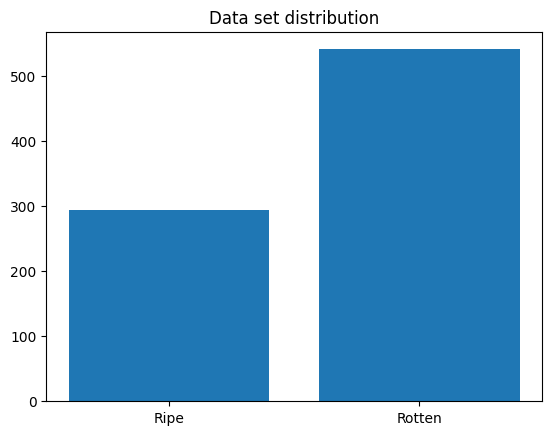

In [3]:
import os
import matplotlib.pyplot as pyplot

dirs = ['mangos_mascaras']
categories = ['Ripe', 'Rotten']

image_count = {}

for directory in dirs:
    count = 0
    for category in categories:
        image_count.setdefault(directory, {})
        image_count[directory][category] = len(os.listdir(os.path.join(directory, category)))

pyplot.title('Data set distribution')
pyplot.bar(image_count['mangos_mascaras'].keys(), image_count['mangos_mascaras'].values())
pyplot.show()

# Cargado de las imágenes en escala de grises y aplicación de las máscaras correspondientes

In [4]:
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import os

paths = ['mangos_mascaras/Ripe/', 'mangos_mascaras/Rotten/', 'mangos_mascaras/ripe_masks/', 'mangos_mascaras/rotten_masks/']

def load_mask(path):
    mask = np.load(path)
    mask = ski.util.img_as_ubyte(mask)

    if len(mask.shape) == 3:
        mask = ski.color.rgb2gray(mask)

    return mask

def load_image(path):
    image = ski.io.imread(path)
    image = ski.util.img_as_ubyte(image)

    if len(image.shape) == 3 and image.shape[-1] == 4:
        image = ski.color.rgba2gray(image)
    
    if len(image.shape) == 3 and image.shape[-1] == 3:
        image = ski.color.rgb2gray(image)

    return image

labels = [
    *['Ripe' for _ in os.listdir(paths[0])],
    *['Rotten' for _ in os.listdir(paths[1])],
]

paths = [
    *[paths[0] + path for path in os.listdir(paths[0])],
    *[paths[1] + path for path in os.listdir(paths[1])],
]

images = [
    *[load_image(path) for path in paths]
]

image_set = list(zip(labels, images, paths))

masks = [
    load_mask(
        path.replace(label, label.lower() + '_masks').replace('.jpg', '').replace('.jpeg', '') + 
        '_mask_mask_' + label.lower() + '.npy'
    ) for label, _, path in image_set
]

image_set = list(zip(labels, images, masks, paths))

# Quitamos las máscaras que no tienen la misma resolución que la imagen correspondiente
image_set = list(filter(lambda image: image[1].shape == image[2].shape, image_set))

image_set = [(label, image * mask, path) for label, image, mask, path in image_set]

# Una breve inspección de las imágenes

Rotten
mangos_mascaras/Rotten/img641.jpg


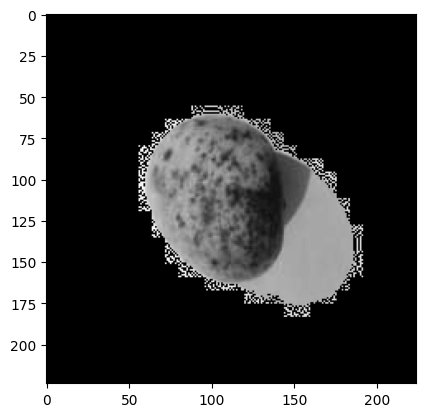

Ripe
mangos_mascaras/Ripe/img368.jpg


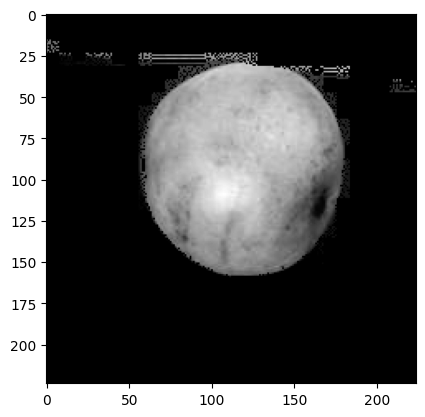

In [5]:
found_errors = [408, 180]

for index in found_errors:
    label, masked, path = image_set[index]
    print(label)
    print(path)
    plt.imshow(masked, cmap='gray'); plt.show()

# Extracción de características

In [95]:
from statistics import mean, variance

feature_vector = {
    'category':             [label for label, image, path in image_set],
    'blur_efect_2':         [ski.measure.blur_effect(image, h_size=2) for label, image, path in image_set],
    'blur_efect_10':        [ski.measure.blur_effect(image, h_size=10) for label, image, path in image_set],
    'blur_efect_30':        [ski.measure.blur_effect(image, h_size=30) for label, image, path in image_set],
    'blur_efect_60':        [ski.measure.blur_effect(image, h_size=60) for label, image, path in image_set],
#   'perimeter':            [ski.measure.perimeter(image) for label, image, path in image_set],
    'euler_number':         [ski.measure.euler_number(image, connectivity=4) for label, image, path in image_set],
    'shannon_entropy':      [ski.measure.shannon_entropy(image, base=2) for label, image, path in image_set],
    'hog_mean':             [mean(ski.feature.hog(image, orientations=4, feature_vector=True)) for label, image, path in image_set],
    'hog_variance':         [variance(ski.feature.hog(image,  orientations=4, feature_vector=True)) for label, image, path in image_set],
    'intensity_mean':       [mean(image.flatten()) for label, image, path in image_set],
    'intensity_variance':   [variance(image.flatten()) for label, image, path in image_set],
}


# Guardar el vector de caracterísitcas

In [96]:
import pickle

with open('features.f', 'wb') as f:
    pickle.dump(feature_vector, f)
    f.close()

# Leer el vector de características

In [190]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

with open('features.f', 'rb') as f:
    feature_vector_ = pickle.load(f)
    f.close()

image_data = pd.DataFrame.from_dict(feature_vector_)
image_data.info()
image_data.describe()

X = image_data.drop('category', axis=1)
Y = image_data['category']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            834 non-null    object 
 1   blur_efect_2        834 non-null    float64
 2   blur_efect_10       834 non-null    float64
 3   blur_efect_30       834 non-null    float64
 4   blur_efect_60       834 non-null    float64
 5   euler_number        834 non-null    int64  
 6   shannon_entropy     834 non-null    float64
 7   hog_mean            834 non-null    float64
 8   hog_variance        834 non-null    float64
 9   intensity_mean      834 non-null    float64
 10  intensity_variance  834 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 71.8+ KB


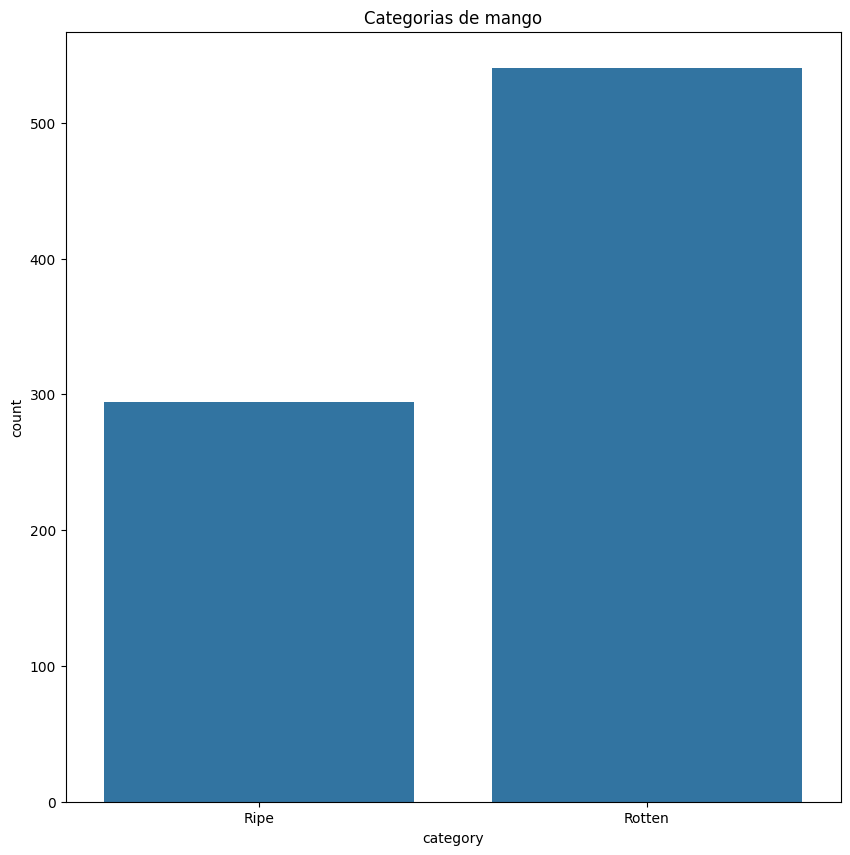

In [191]:
import seaborn as sns

ax = plt.subplots(1,1,figsize=(10,10))
sns.countplot(x='category',data=image_data)
plt.title("Categorias de mango")
plt.show()

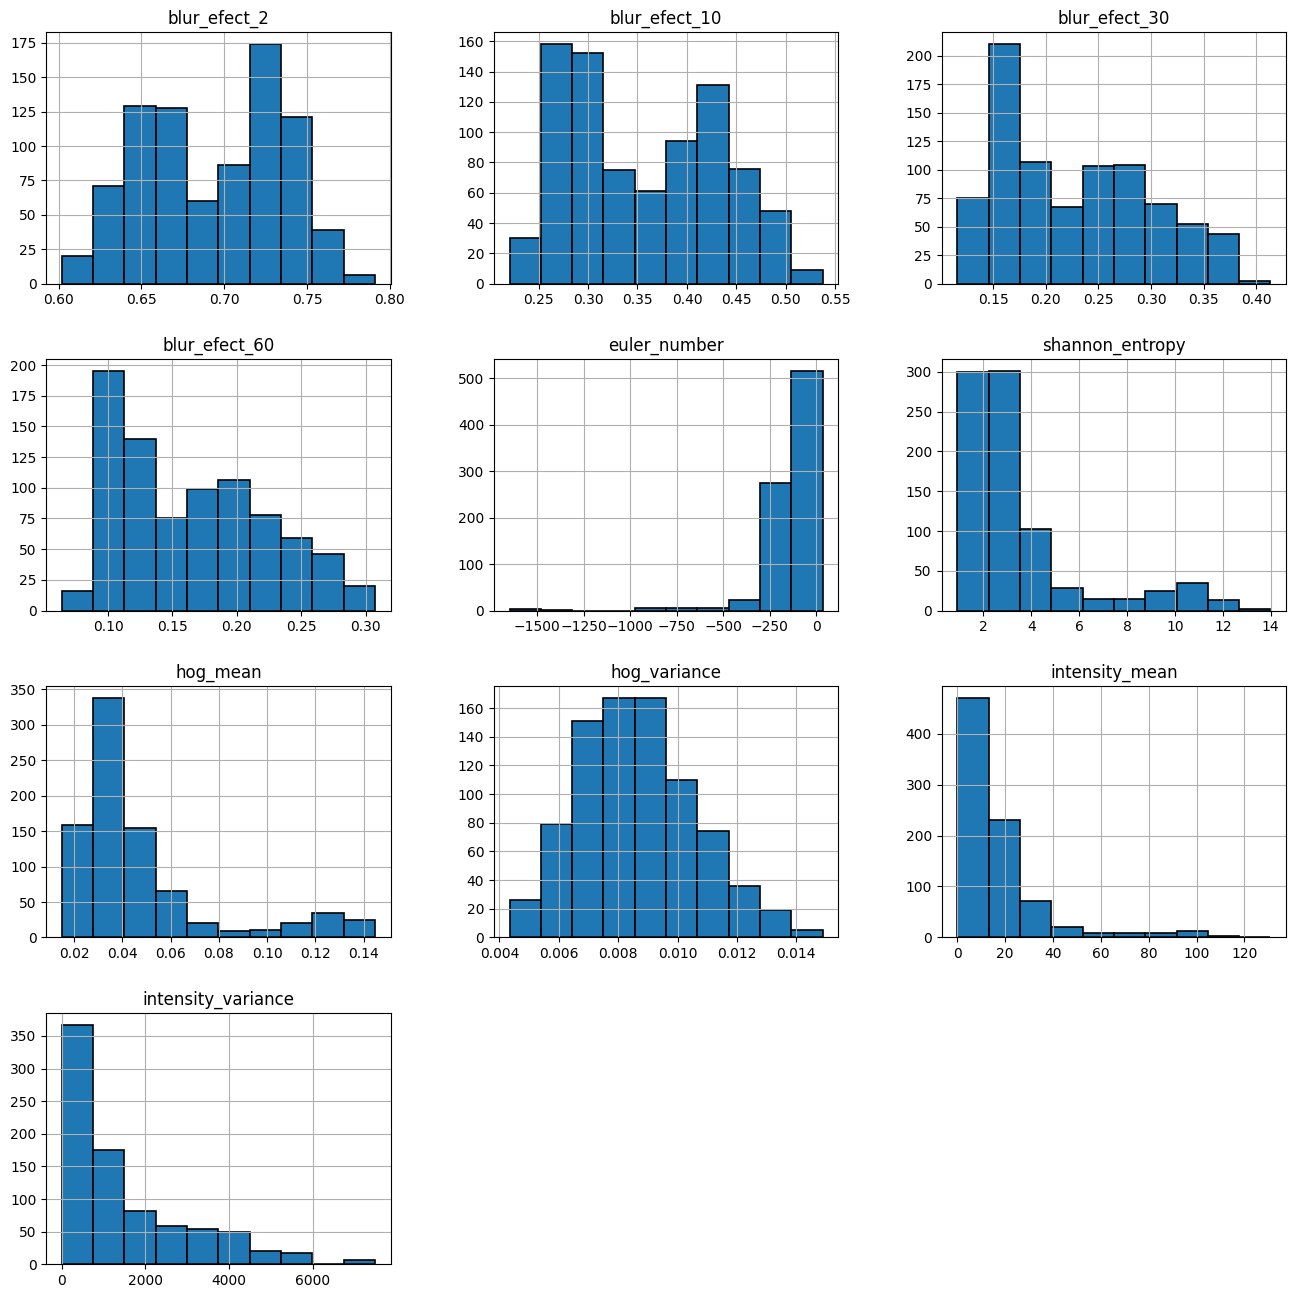

In [192]:
X.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(16,16)
plt.show()

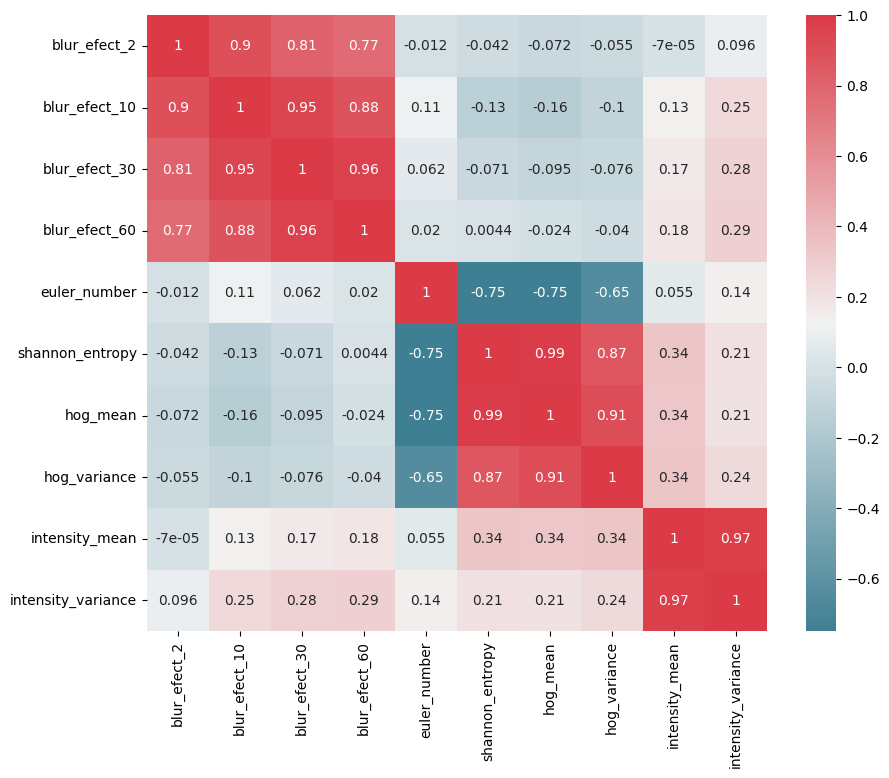

In [193]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr(method='spearman')
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)
plt.show() 

In [194]:
def corr_feature_detect(data, threshold):
     
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups

In [195]:
corr = corr_feature_detect(data=X,threshold=0.95)
for i in corr:
    print(i,'\n')
if len(corr) == 0:
    print('No hay variables correlacionadas')

          feature1  feature2    corr
0  shannon_entropy  hog_mean  0.9853 

        feature1       feature2      corr
2  blur_efect_60  blur_efect_30  0.971967 

        feature1       feature2      corr
4  blur_efect_10  blur_efect_30  0.958876 



array([[<Axes: xlabel='shannon_entropy', ylabel='shannon_entropy'>,
        <Axes: xlabel='hog_mean', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_30', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_60', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_10', ylabel='shannon_entropy'>,
        <Axes: xlabel='blur_efect_2', ylabel='shannon_entropy'>],
       [<Axes: xlabel='shannon_entropy', ylabel='hog_mean'>,
        <Axes: xlabel='hog_mean', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_30', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_60', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_10', ylabel='hog_mean'>,
        <Axes: xlabel='blur_efect_2', ylabel='hog_mean'>],
       [<Axes: xlabel='shannon_entropy', ylabel='blur_efect_30'>,
        <Axes: xlabel='hog_mean', ylabel='blur_efect_30'>,
        <Axes: xlabel='blur_efect_30', ylabel='blur_efect_30'>,
        <Axes: xlabel='blur_efect_60', ylabel='blur_efect_30'>,
   

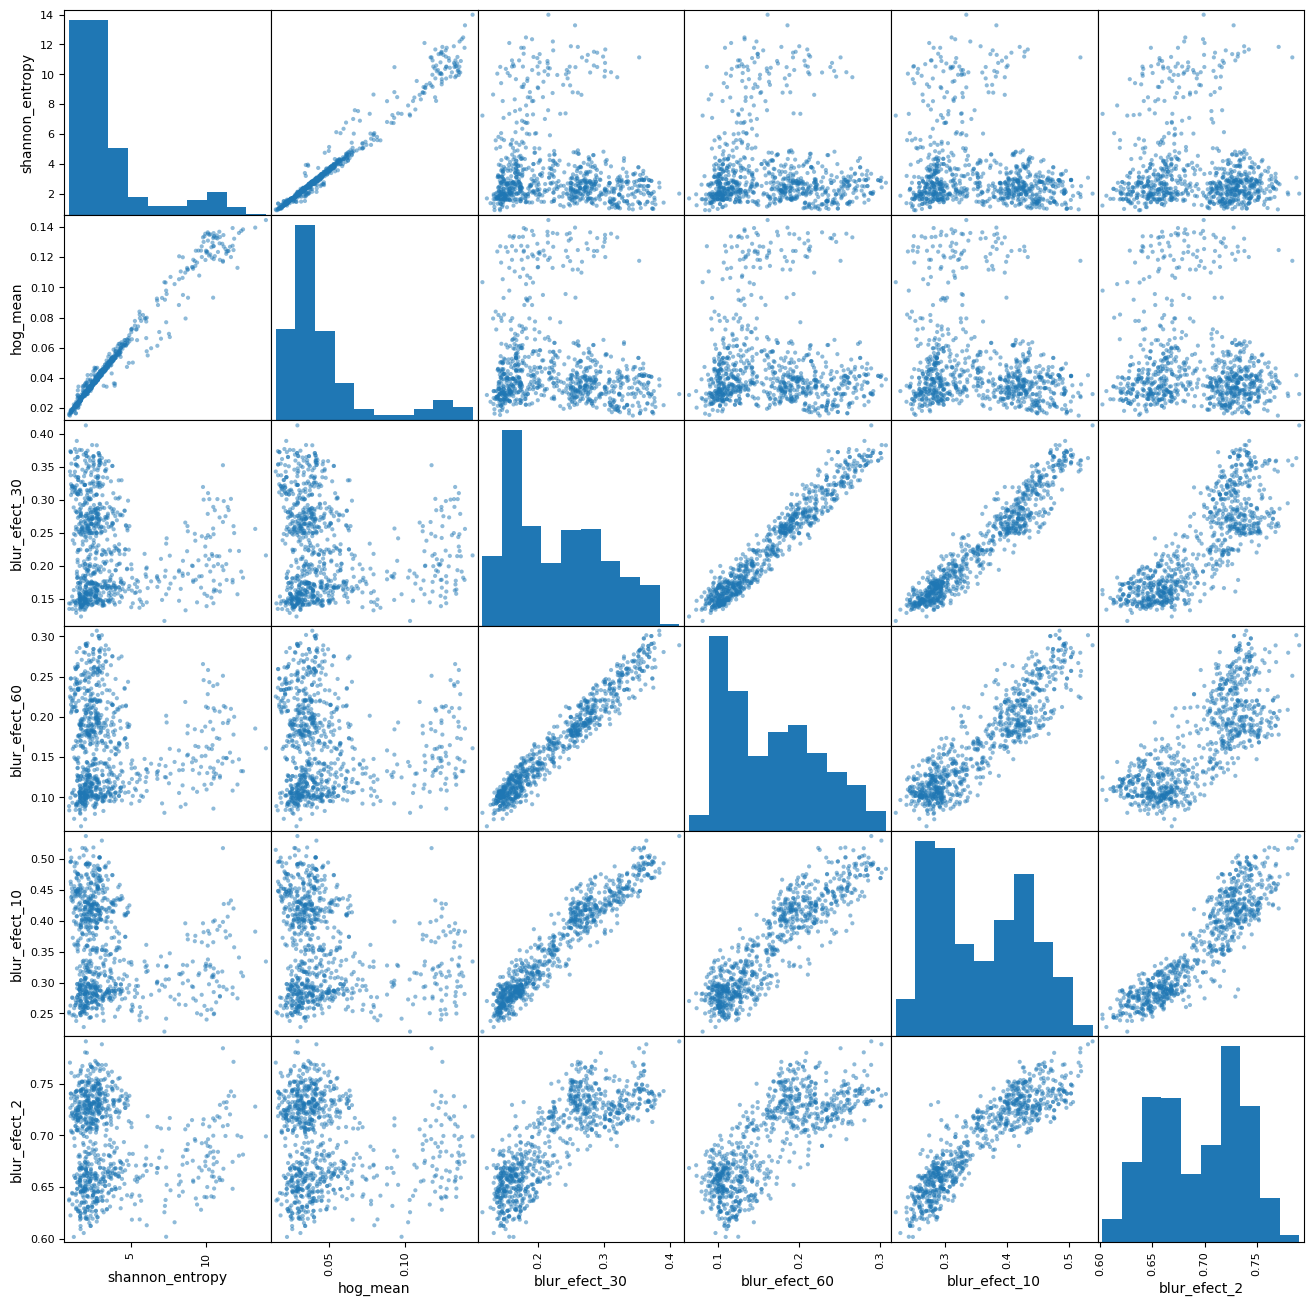

In [196]:
from pandas.plotting import scatter_matrix

cols = ['shannon_entropy', 'hog_mean', "blur_efect_30", 'blur_efect_60', 'blur_efect_10', 'blur_efect_2']
scatter_matrix(X[cols], figsize=(16, 16))

In [197]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_ = scaler.fit_transform(X)

In [334]:
# Partición del conjunto de datos en entrenamiento y prueba. 30% para pruebas
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_, Y, test_size=0.25, random_state=420)

# Clasificación usando Regresión Logística

In [335]:
from sklearn.linear_model import LogisticRegression
softreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty=None, max_iter=10000)
softreg_model.fit(Xtrain, Ytrain)

/home/mehill/uni/ia/mango/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=10000, multi_class='multinomial', penalty=None)

In [336]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

Ytrain_predicted = softreg_model.predict(Xtrain)

print("Matriz de confusion para los datos de entrenamiento:\n%s" % metrics.confusion_matrix(Ytrain, Ytrain_predicted))
print('Accuracy', accuracy_score(Ytrain, Ytrain_predicted))

Matriz de confusion para los datos de entrenamiento:
[[196  23]
 [ 14 392]]
Accuracy 0.9408


In [330]:
Ytest_predicted = softreg_model.predict(Xtest)
print("Matriz de confusion para los datos de prueba:\n%s" % metrics.confusion_matrix(Ytest, Ytest_predicted))
print('Accuracy: ', accuracy_score(Ytest, Ytest_predicted))

Matriz de confusion para los datos de prueba:
[[ 79   7]
 [ 10 155]]
Accuracy:  0.9322709163346613


## Descarte de variables
### Lasso

In [331]:
softreg_lasso = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', C=0.5, max_iter=5000)
softreg_lasso.fit(Xtrain, Ytrain)

/home/mehill/uni/ia/mango/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.5, max_iter=5000, multi_class='multinomial',
                   penalty='l1', solver='saga')

In [332]:
y_train_predicted_softreg_lasso = softreg_lasso.predict(Xtrain)
y_test_predicted_softreg_lasso  = softreg_lasso.predict(Xtest)

print('Accuracy con los datos de entrenamiento: ', accuracy_score(Ytrain, y_train_predicted_softreg_lasso))
print('Accuracy: con los datos de prueba', accuracy_score(Ytest, y_test_predicted_softreg_lasso))

Accuracy con los datos de entrenamiento:  0.9296740994854202
Accuracy: con los datos de prueba 0.9163346613545816


In [333]:
coefficients = softreg_lasso.coef_
zero_features_across_classes = np.all(coefficients == 0, axis=0)
zeroed_feature_indices = np.where(zero_features_across_classes)[0]
print(zeroed_feature_indices)

[5 6]


# Clasificación usando Arboles de decisión

In [354]:
from sklearn import tree

decision_tree_model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=7)
decision_tree_model.fit(Xtrain, Ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [356]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Ypred = decision_tree_model.predict(Xtest)

accuracy = decision_tree_model.score(Xtest, Ytest)
accuracy_ = decision_tree_model.score(Xtrain, Ytrain)
cmatrix = confusion_matrix(Ytest, Ypred)

print('Matriz de confusión usando un árbol de decisión:')
print(cmatrix)
print('Accuracy: {:.2f}'.format(accuracy)) 
print('Accuracy (datos de entrenamiento): {:.2f}'.format(accuracy_)) 

print(classification_report(Ytest, Ytest))
print(X.columns)

Matriz de confusión usando un árbol de decisión:
[[ 60  15]
 [  4 130]]
Accuracy: 0.91
Accuracy (datos de entrenamiento): 0.97
              precision    recall  f1-score   support

        Ripe       1.00      1.00      1.00        75
      Rotten       1.00      1.00      1.00       134

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Index(['blur_efect_2', 'blur_efect_10', 'blur_efect_30', 'blur_efect_60',
       'euler_number', 'shannon_entropy', 'hog_mean', 'hog_variance',
       'intensity_mean', 'intensity_variance'],
      dtype='object')


# Clasificación usando Random Forest

# Clasificación utilizando Redes Neuronales

# Conclusión